<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_5/xp5_transformer_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration 5. A Transformer Chatbot

**Goal**

* 트랜스포머의 인코더 디코더 구조 이해할 수 있습니다.
* 내부 단어 토크나이저 사용할 수 있습니다.
* 셀프 어텐션 이해할 수 있습니다.
* 한국어에도 적용할 수 있습니다.

**Index**

    1. 챗봇과 딥러닝
    2. 트랜스포머와 인코더 디코더
    3. 트랜스포머의 입력 이해하기
    4. Attention Mechanism
    5. Scaled Dot-Product Attention
    6. Multi-head Attention
    7. Masking
    8. Encoder
    9. Decoder
    10. 챗봇의 병렬 데이터 받아오기
    11. 병렬 데이터 전처리하기
    12. 모델 정의 및 학습하기
    13. 챗봇 테스트하기

### 챗봇과 딥러닝

[What is a Deep Learning Chatbot?](https://shanebarker.com/blog/deep-learning-chatbot/)  
[A Transformer Chatbot Tutorial with TensorFlow 2.0](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html)  
[Small Transformer for Korean chatbot (pytorch)](https://www.kaggle.com/code/fleek12/small-transformer-for-korean-chatbot-pytorch)  

### 트랜스포머와 인코더 디코더

[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
[What are Encoder in Transformers](https://www.scaler.com/topics/nlp/transformer-encoder-decoder/)  
[Transformers-based Encoder-Decoder Models](https://huggingface.co/blog/encoder-decoder)

The encoder processes encode the input data, and the decoder generates the output data based on the encoded representation, which serves as the "context" for the decoder. The encoder is essential for the transformer's processing and understanding of complex input data.

![](https://drive.google.com/uc?export=view&id=1kguZmZ8VpsW_jjyH-rUh2mMpcqI7sewP)

### 트랜스포머의 입력 이해하기

In [ ]:
# Set up

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

print("tensorflow", tf.__version__)

tensorflow 2.6.0


`Positional Matrix`의 원리는 다음과 같습니다. `Positional Matrix`를 구현해 봅시다.

![](https://drive.google.com/uc?export=view&id=1vZfr9N7I3y2B9nfn-4kr2UDKdD6hoJbK)

In [ ]:
# Positional Encoding Layer

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # Create an array of angles
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # Apply sin function to even indices of array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # Apply cosine function to odd indices of array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # Rearrange sin and cosine so that they intersect
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Gotcha")

Gotcha


`행의 크기가 50, 열의 크기가 512인 행렬`을 그려봅시다. 최대 문장의 길이가 50이고, 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

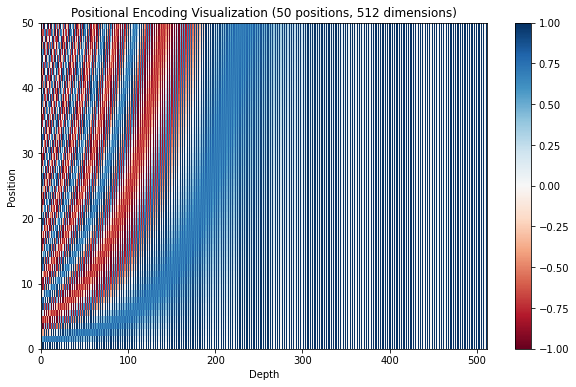

In [ ]:
position = 50
d_model = 512
pos_encoding_layer = PositionalEncoding(position, d_model)
sample_pos_encoding = pos_encoding_layer.pos_encoding.numpy()

plt.figure(figsize=(10, 6))
plt.pcolormesh(sample_pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encoding Visualization (50 positions, 512 dimensions)')
plt.show()

`최대 문장의 길이가 30`이고, `워드 임베딩 차원을 256`으로 하는 모델의 입력 벡터 모양은 어떨까요? 확인해 봅시다.

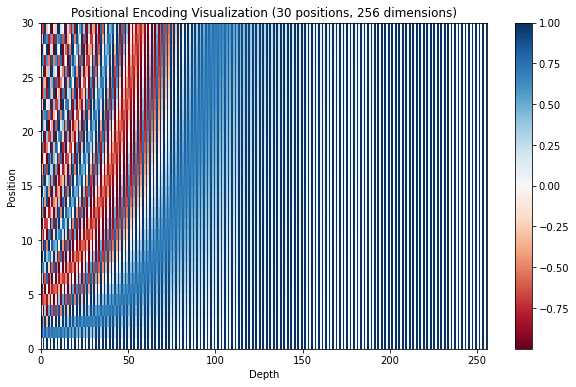

In [ ]:
position = 30
d_model = 256
pos_encoding_layer = PositionalEncoding(position, d_model)
sample_pos_encoding = pos_encoding_layer.pos_encoding.numpy()

plt.figure(figsize=(10, 6))
plt.pcolormesh(sample_pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encoding Visualization (30 positions, 256 dimensions)')
plt.show()

### Attention Mechanism

[The Transformer Attention Mechanism](https://machinelearningmastery.com/the-transformer-attention-mechanism/)  
[Transformer: A Novel Neural Network Architecture for Language Understanding](https://blog.research.google/2017/08/transformer-novel-neural-network.html)

### Scaled Dot-Product Attention

[How to Implement Scaled Dot-Product Attention from Scratch in TensorFlow and Keras](https://machinelearningmastery.com/how-to-implement-scaled-dot-product-attention-from-scratch-in-tensorflow-and-keras/)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):

  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # normalize the weights
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # Add mask to padding
  if mask is not None:
    logits += (mask * -1e9)

  # softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # The final attention is the weight and the dot product of V.
  output = tf.matmul(attention_weights, value)
  return output

### Multi-head Attention

[Hugging Face - T5, num_heads](https://huggingface.co/transformers/v3.0.2/model_doc/t5.html)  
[Transformers Explained Visually (Part 3): Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)  
[TensorFlow - tf.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)  

`num_heads` – Number of attention heads for each attention layer in the Transformer encoder. num_heads can also be accessed via the property num_attention_heads.

`Multiple Attention Heads` - In the Transformer, the Attention module repeats its computations multiple times in parallel. Each of these is called an Attention Head. The Attention module splits its Query, Key, and Value parameters N-ways and passes each split independently through a separate Head. All of these similar Attention calculations are then combined together to produce a final Attention score. This is called Multi-head attention and gives the Transformer greater power to encode multiple relationships and nuances for each word.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q. Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Q. 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Scaled dot-product attention function
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # After the attention operation, each result is concatenated again.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # Apply Dense once more to the final result
    outputs = self.dense(concat_attention)

    return outputs

### Masking

[TensorFlow - Understanding masking & padding](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding)  
[TensorFlow - Module: tf.keras.preprocessing.sequence](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence)  
[TensorFlow - tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)  
[TensorFlow - Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)  

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

두 개의 정수 시퀀스를 입력하고, 각각 어떤 결과가 나오는지 확인해 봅시다.

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [ ]:
# ref, https://www.tensorflow.org/tutorials/text/transformer

# def create_look_ahead_mask(size):
#   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
#   return mask  # (seq_len, seq_len)

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Encoder

두 개의 서브 층, 즉 셀프 어텐션과 피드 포워드 신경망을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다.

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Multi-head attention (self-attention)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Dropout and LayerNormalization are performed on the results of attention.
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Two fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout and LayerNormalization are performed on the results of the fully connected layer.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

디코더는 세 개의 서브 층으로 구성됩니다. 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Multi-head attention (self-attention)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # The result of multi-head attention performs LayerNormalization.
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Masked Multi-head attention (encoder-decoder attention)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # The result of Masked Multi-head attention performs Dropout and LayerNormalization.
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # Two fully connected layers
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout and LayerNormalization are performed on the results of the fully connected layer.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 챗봇의 병렬 데이터 받아오기

[Cornell Univ. - Cornell Movie-Dialogs Corpus Dataset](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)  
[Cornell Movie-Dialogs Corpus Dataset Details](https://convokit.cornell.edu/documentation/movie.html)  

**Goal**

* 정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.
* 문장에서 단어와 구두점 사이에 공백을 추가한다.
* 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

데이터 중에서 50000 개만 가져오도록 하고, 질문과 답변의 페어 형태로 데이터셋을 가공합니다.

In [ ]:
MAX_SAMPLES = 50000

print(MAX_SAMPLES)

50000


In [ ]:
def preprocess_sentence(sentence):
  # Q. 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # Q. (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 페어를 전처리합니다.

In [ ]:
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

로드한 데이터의 샘플 수를 확인해 봅시다.

In [ ]:
questions, answers = load_conversations()
print('Total Questions:', len(questions))
print('Total Answers:', len(answers))

Total Questions: 50000
Total Answers: 50000


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 합니다. 둘 다 5만 개의 샘플이 저장되었습니다.  
임의로 인덱스 21의 샘플을 출력해서 질문과 답변이 병렬적으로 잘 저장 되었는지 그리고 의도했던 전처리가 진행되었는지 확인해 봅시다.

In [ ]:
print('Sample question after preprocessing: {}'.format(questions[21]))
print('Sample answer after preprocessing: {}'.format(answers[21]))

Sample question after preprocessing: she s not a . . .
Sample answer after preprocessing: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


### 병렬 데이터 전처리하기

**Goal**

* TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  
* 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.
* 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
* 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
* MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.  

각 단어에 고유한 정수 인덱스를 부여하기 위해 질문과 답변 데이터셋을 모두 사용하여 단어장 `Vocabulary`를 만듭니다.

In [ ]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

디코더의 문장 생성 과정에서 사용할 `시작 토큰`과 `종료 토큰`에 대해서도 임의로 단어장에 추가하여 정수를 부여합니다.  
이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 `1`이 큰 수를 번호로 부여합니다.

In [ ]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

`시작 토큰`과 `종료 토큰`에 부여된 정수를 출력해 봅시다.

In [ ]:
print('START_TOKEN:' ,[tokenizer.vocab_size])
print('END_TOKEN:' ,[tokenizer.vocab_size + 1])

START_TOKEN: [8331]
END_TOKEN: [8332]


각각 `8,331`과 `8,332`라는 점에서 현재 단어장의 크기가 `8,331(0번부터 8,330번)` 임을 알 수 있습니다.  
`시작 토근`과 `종료 토큰` 두 개의 토큰을 추가해 주었으므로 `단어장의 크기도 +2 임`을 명시해 주어야 합니다.

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size + 2

print(VOCAB_SIZE)

8333


위에서 `tensorflow_datasets`의 `SubwordTextEncoder`를 사용해서 `tokenizer`를 정의하고 Vocabulary를 만들었습니다.  
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고, tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.  
22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 확인해 봅시다.

In [ ]:
print('Question sample after integer encoding: {}'.format(tokenizer.encode(questions[21])))
print('Answer sample after integer encoding: {}'.format(tokenizer.encode(answers[21])))

Question sample after integer encoding: [60, 8, 37, 8172, 49]
Answer sample after integer encoding: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다.  
위의 결과와 마찬가지로 질문과 답변 페어에 대해서 전부 정수 인코딩을 수행합니다.  
이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 padding 합니다.  

In [ ]:
# Maximum allowable length of sample or final length after padding

MAX_LENGTH = 40

print(MAX_LENGTH)

40


In [ ]:
# Integer encoding, removing samples exceeding maximum length & padding
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # Add start token and end token during integer encoding process
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # Accepted as a dataset only if the maximum length is 40 or less.
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # Padding all datasets to a maximum length of 40
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다.  
단어장의 크기와 샘플의 개수를 확인해 봅시다.

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('Size of Vocabulary :',(VOCAB_SIZE))
print('Number of sample questions after filtering: {}'.format(len(questions)))
print('Number of sample answers after filtering: {}'.format(len(answers)))

Size of Vocabulary : 8333
Number of sample questions after filtering: 44095
Number of sample answers after filtering: 44095


질문과 답변 페어를 `tf.data.Dataset API`의 입력으로 사용하여 파이프라인을 구성합니다.    
이 때, `Teacher Forcing`을 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용합니다.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# The decoder uses the previous target as the next input.
# Accordingly, remove START_TOKEN from outputs.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 학습하기

앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 `트랜스포머 함수`를 정의합니다.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Mask for padding in the encoder
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # Used by the decoder to mask future tokens.
  # A padded mask is also included internally.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # Masking the vectors of the encoder in the second attention block
  # Mask for padding in the decoder
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Encoder
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Decoder
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # Fully connected layer
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2
D_MODEL = 256 # Fixed dimensionality of input and output inside encoder and decoder
NUM_HEADS = 8 # Number of heads in multi-head attention
UNITS = 512 # Size of hidden layer in feed forward neural network
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용합니다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 사용하고 있습니다. 이런 방법을 `Custom Learning rate Scheduling`이라고 합니다.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

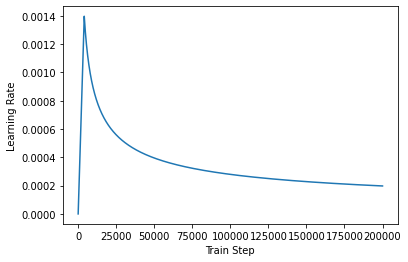

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

손실 함수와 커스텀 된 learning rate를 사용하여 모델을 컴파일합니다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 10

model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
689/689 [==============================] - 45s 56ms/step - loss: 2.1098 - accuracy: 0.0423
Epoch 2/10
689/689 [==============================] - 38s 55ms/step - loss: 1.4992 - accuracy: 0.0790
Epoch 3/10
689/689 [==============================] - 38s 55ms/step - loss: 1.3940 - accuracy: 0.0859
Epoch 4/10
689/689 [==============================] - 38s 55ms/step - loss: 1.3348 - accuracy: 0.0904
Epoch 5/10
689/689 [==============================] - 38s 55ms/step - loss: 1.2846 - accuracy: 0.0944
Epoch 6/10
689/689 [==============================] - 38s 55ms/step - loss: 1.2379 - accuracy: 0.0980
Epoch 7/10
689/689 [==============================] - 38s 55ms/step - loss: 1.1841 - accuracy: 0.1021
Epoch 8/10
689/689 [==============================] - 38s 55ms/step - loss: 1.1235 - accuracy: 0.1074
Epoch 9/10
689/689 [==============================] - 38s 55ms/step - loss: 1.0672 - accuracy: 0.1129
Epoch 10/10
689/689 [==============================] - 38s 55ms/step - loss: 1.014

### 챗봇 테스트하기

`Inference` 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 `decoder_inference()` 함수를 만듭니다.

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # After encoding the input sentence as an integer, add the start token and end token back and forth.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # A variable in which the current predicted output sequence of the decoder is persistently stored.
  # Since there is no prediction at first, only the starting token is stored separately. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # Inference stage of the decoder
  for i in range(MAX_LENGTH):
    # The decoder repeats next word prediction up to a length of MAX_LENGTH.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # Integer of the currently predicted word
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # If the currently predicted word is a termination token, terminate the for statement.
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # Predicted words are continuously added to output_sequence
    # This output_sequence again becomes the input to the decoder.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 `decoder_inference()` 함수를 호출하여 챗봇의 대답을 얻는 `sentence_generation()` 함수를 만듭니다.

In [ ]:
def sentence_generation(sentence):
  # The decoder is operated on the input sentence and a predicted integer sequence is returned.
  prediction = decoder_inference(sentence)

  # Converts a sequence of integers back to a text sequence.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input : {}'.format(sentence))
  print('Output : {}'.format(predicted_sentence))

  return predicted_sentence

임의의 문장에 대한 챗봇의 대답을 확인해 볼까요?

In [ ]:
sentence_generation('Where have you been?')

Input : Where have you been?
Output : i m a little girl .


'i m a little girl .'

In [ ]:
sentence_generation("In your dreams.")

Input : In your dreams.
Output : you re a fucking girl !


'you re a fucking girl !'

`you re a very dump one . `